In [119]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [229]:
df = pd.read_csv('rawdata/USvideos.csv')

In [121]:
df.isnull().sum()

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64

In [122]:
df = df.drop(columns=['description', 'video_id', 'thumbnail_link', 'video_error_or_removed'])
df

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled
0,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,False,False
1,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,False,False
2,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,False,False
3,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,False,False
4,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
40944,18.14.06,The Cat Who Caught the Laser,AaronsAnimals,15,2018-05-18T13:00:04.000Z,"aarons animals|""aarons""|""animals""|""cat""|""cats""...",1685609,38160,1385,2657,False,False
40945,18.14.06,True Facts : Ant Mutualism,zefrank1,22,2018-05-18T01:00:06.000Z,[none],1064798,60008,382,3936,False,False
40946,18.14.06,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,Brad Mondo,24,2018-05-18T17:34:22.000Z,I gave safiya nygaard a perfect hair makeover ...,1066451,48068,1032,3992,False,False
40947,18.14.06,How Black Panther Should Have Ended,How It Should Have Ended,1,2018-05-17T17:00:04.000Z,"Black Panther|""HISHE""|""Marvel""|""Infinity War""|...",5660813,192957,2846,13088,False,False


# Feature Engineering

In [230]:
import seaborn as sns

# feature list
# trending_date	,trending_date, title, channel_title, category_id, publish_time,tags , views, likes , dislikes , comment_count, comments_disabled,ratings_disabled

# engineering publish_time

df['at_what_hour'] = pd.to_datetime(df['publish_time']).dt.hour
df['dayofweek'] = pd.to_datetime(df['publish_time']).dt.dayofweek

# engineering trending_date

df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m').dt.tz_localize('UTC')
df['how_long_till_trending'] = (df['trending_date'] - pd.to_datetime(df['publish_time'])).dt.total_seconds()


# engineering comments_disabled, ratings_disabled

df['comments_disabled'] = df['comments_disabled'].astype(int)
df['ratings_disabled'] = df['ratings_disabled'].astype(int)


df.drop(columns=['publish_time', 'trending_date', 'category_id'], inplace=True)

# # Normalize numeric features
# numeric_features = ['views', 'likes', 'dislikes', 'comment_count', 'at_what_hour', 'dayofweek', 'how_long_till_trending']

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df[numeric_features] = scaler.fit_transform(df[numeric_features])



# Vector Embedding

In [ ]:
# make vector embedding using sentence transformers
from sentence_transformers import SentenceTransformer


model = SentenceTransformer('all-MiniLM-L6-v2')
title_embedding = model.encode(df['title'].astype(str).tolist(), show_progress_bar=True)
channel_title_embedding= model.encode(df['channel_title'].astype(str).tolist(), show_progress_bar=True)
tags_embedding = model.encode(df['tags'].astype(str).tolist(), show_progress_bar=True)


c:\Users\25194\Desktop\SubCancelationPrediction\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\25194\Desktop\SubCancelationPrediction\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\25194\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run 

# Saving Embedding vectors

In [ ]:
# concatenate embeddings with the dataframe

print(title_embedding.shape)
print(channel_title_embedding.shape)
print(tags_embedding.shape)


np.save('title_embedding.npy', title_embedding)
np.save('channel_title_embedding.npy', channel_title_embedding)
np.save('tags_embedding.npy', tags_embedding)

(40949, 384)
(40949, 384)
(40949, 384)


# Concatenateing the embedded features with normal numeric features

In [231]:
numeric_features = ['likes', 'dislikes', 'comment_count', 'at_what_hour', 'dayofweek', 'how_long_till_trending']
X = np.concatenate((title_embedding, channel_title_embedding, tags_embedding, df[numeric_features].values), axis=1)
Y = df['views'].values
X.shape, Y.shape


((40949, 1158), (40949,))

# Splitting for training 

In [232]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((32759, 1158), (8190, 1158), (32759,), (8190,))

# XGboost 

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
xgb_model  = XGBRegressor(n_estimators=100,random_state=42 ,tree_method='hist', device='cuda')
xgb_model.fit(X_train, Y_train)
xgb_y_pred = xgb_model.predict(X_test)
print("XGBoost MSE:", mean_squared_error(Y_test, xgb_y_pred))
print("XGBoost R^2 Score:", r2_score(Y_test, xgb_y_pred))

XGBoost MSE: 620588630016.0
XGBoost R^2 Score: 0.9871116876602173


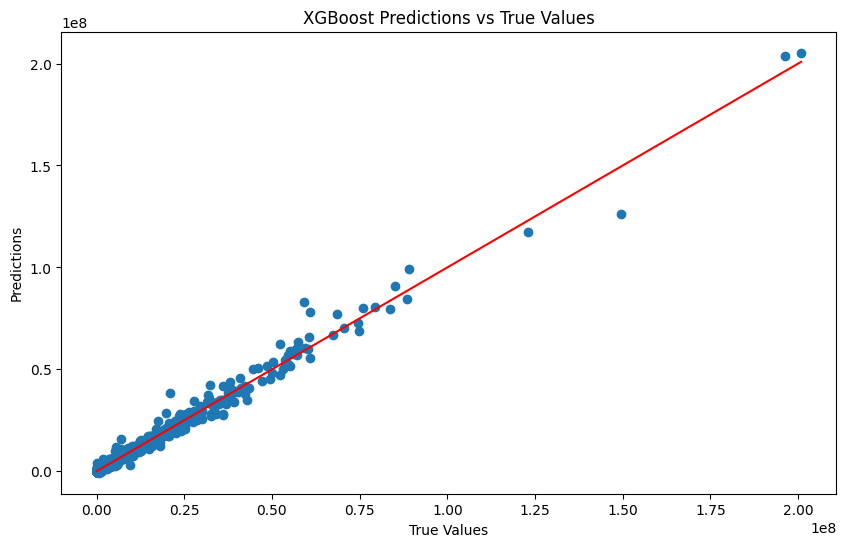

In [234]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, xgb_y_pred, alpha=1)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('XGBoost Predictions vs True Values')
plt.show()

In [235]:
test_df= pd.read_csv('rawdata/CAvideos.csv')

In [ ]:
test_df = test_df.drop(columns=['description', 'video_id', 'thumbnail_link', 'video_error_or_removed'])
test_df['at_what_hour'] = pd.to_datetime(test_df['publish_time']).dt.hour
test_df['dayofweek'] = pd.to_datetime(test_df['publish_time']).dt.dayofweek
# engineering trending_date
test_df['trending_date'] = pd.to_datetime(test_df['trending_date'], format='%y.%d.%m').dt.tz_localize('UTC')
test_df['how_long_till_trending'] = (test_df['trending_date'] - pd.to_datetime(test_df['publish_time'])).dt.total_seconds()
# engineering comments_disabled, ratings_disabled
test_df['comments_disabled'] = test_df['comments_disabled'].astype(int)
test_df['ratings_disabled'] = test_df['ratings_disabled'].astype(int)
test_df.drop(columns=['publish_time', 'trending_date', 'category_id'], inplace=True)
# Normalize numeric features
numeric_features = ['likes', 'dislikes', 'comment_count', 'at_what_hour', 'dayofweek', 'how_long_till_trending']

In [ ]:
from sentence_transformers import SentenceTransformer
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('all-MiniLM-L6-v2')
model = model.to(device)  
test_title_embedding = model.encode(test_df['title'].astype(str).tolist(), show_progress_bar=True, batch_size=64)
test_channel_title_embedding = model.encode(test_df['channel_title'].astype(str).tolist(), show_progress_bar=True, batch_size=64)
test_tags_embedding = model.encode(test_df['tags'].astype(str).tolist(), show_progress_bar=True, batch_size=64)

Batches: 100%|██████████| 1278/1278 [15:19<00:00,  1.39it/s]


# Test on Unseen New Data

XGBoost Test MAE: 436446.84375
XGBoost Test MSE: 1197373652992.0
XGBoost Test R^2 Score: 0.8958625197410583


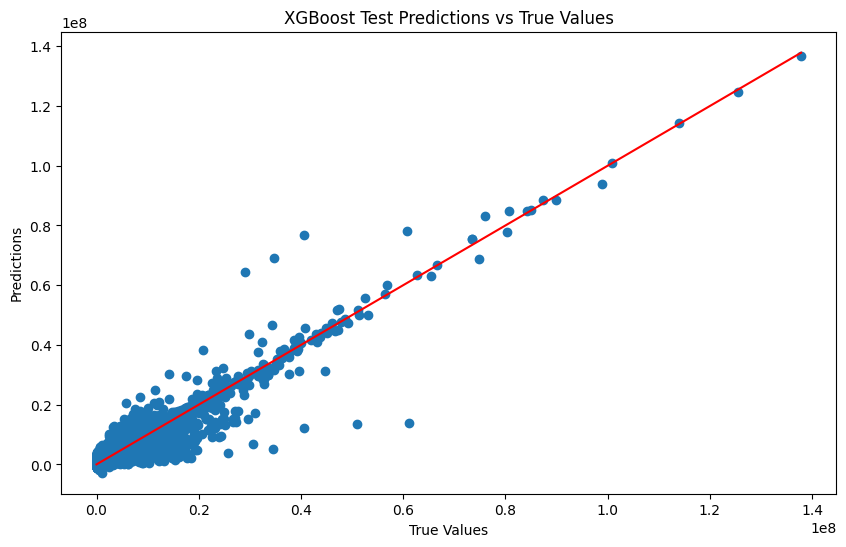

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
test_numeric_features = ['likes', 'dislikes', 'comment_count', 'at_what_hour', 'dayofweek', 'how_long_till_trending']
test_X = np.concatenate((test_title_embedding, test_channel_title_embedding, test_tags_embedding, test_df[test_numeric_features].values), axis=1)
test_Y = test_df['views'].values
xgb_test_y_pred = xgb_model.predict(test_X)
print("XGBoost Test MAE:", mean_absolute_error(test_Y, xgb_test_y_pred))
print("XGBoost Test MSE:", mean_squared_error(test_Y, xgb_test_y_pred))
print("XGBoost Test R^2 Score:", r2_score(test_Y, xgb_test_y_pred))
plt.figure(figsize=(10, 6))
plt.scatter(test_Y, xgb_test_y_pred, alpha=1)
plt.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('XGBoost Test Predictions vs True Values')
plt.show()

In [239]:
print(" List of ten predictions:" , xgb_test_y_pred[:10])

 List of ten predictions: [18485916.    1652733.    3557079.2   2621242.8  30072188.    3176077.8
  4453173.     777167.25  4483176.5    422700.62]
